
final_imbalance_best_sgd2.hdf5 giving best performance

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from os import listdir
from glob import glob
from PIL import Image
import os
import cv2
import scipy.ndimage as ndimage
from skimage import io

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,precision_score,recall_score
from sklearn.metrics import roc_curve,auc

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import load_img, img_to_array
from keras.losses import binary_crossentropy
from keras.models import Sequential,load_model
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization 
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import backend as K
from keras import activations
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers


from numpy import expand_dims


In [4]:
train_df=pd.read_csv("../data/processed/trainpath_df2.csv")
val_df=pd.read_csv("../data/processed/valpath_df2.csv")
test_df=pd.read_csv("../data/processed/testpath_df2.csv")

In [5]:
train_df

,path,P_id,X,Y,Class
0,../data/raw/9036/0/9036_idx5_x1051_y2401_class...,9036,1051,2401,0
1,../data/raw/9036/0/9036_idx5_x2951_y951_class0...,9036,2951,951,0
2,../data/raw/9036/0/9036_idx5_x3001_y1451_class...,9036,3001,1451,0
3,../data/raw/9036/0/9036_idx5_x3051_y801_class0...,9036,3051,801,0
4,../data/raw/9036/0/9036_idx5_x951_y1901_class0...,9036,951,1901,0
...,...,...,...,...,...
187017,../data/raw/8957/1/8957_idx5_x1951_y701_class1...,8957,1951,701,1
187018,../data/raw/8957/1/8957_idx5_x2051_y551_class1...,8957,2051,551,1
187019,../data/raw/8957/1/8957_idx5_x1951_y651_class1...,8957,1951,651,1
187020,../data/raw/8957/1/8957_idx5_x1451_y551_class1...,8957,1451,551,1


In [6]:
def load_data(files):
    X = []
    y = []
    for file in files:
        img = load_img(file, target_size = (50,50))
        pix = img_to_array(img)
        pix /= 255
        X.append(pix)
        if(file[-5] == '1'):
             y.append(1)
        elif(file[-5] == '0'):
            y.append(0)
    return np.stack(X), y

In [7]:
X,y=load_data(train_df.path) #Loading training images into numpy arrays
y=np.vstack(y)
X.shape,y.shape

((187022, 50, 50, 3), (187022, 1))

In [8]:
X_val,y_val=load_data(val_df.path) #Loading validation images into numpy arrays
y_val=np.vstack(y_val)
X_val.shape,y_val.shape

((46084, 50, 50, 3), (46084, 1))

### Training the model with imbalance data

In [9]:
opt=optimizers.SGD(learning_rate=1e-3, momentum=0.9)

In [10]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same", input_shape=(50, 50, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
#model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=opt,
              metrics=['acc'])

checkpoint = ModelCheckpoint("../models/imbalance_best.hdf5", monitor='val_acc', verbose=1,
    save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)



In [11]:
M=model.fit(X, y,validation_data=(X_val, y_val),  epochs=100,batch_size=256, callbacks=[checkpoint,es])

Epoch 1/100
731/731 [==============================] - ETA: 0s - loss: 0.5474 - acc: 0.7499
Epoch 1: val_acc improved from -inf to 0.82200, saving model to ../models/imbalance_best.hdf5
731/731 [==============================] - 50s 67ms/step - loss: 0.5474 - acc: 0.7499 - val_loss: 0.4099 - val_acc: 0.8220
Epoch 2/100
731/731 [==============================] - ETA: 0s - loss: 0.5353 - acc: 0.7565
Epoch 2: val_acc did not improve from 0.82200
731/731 [==============================] - 55s 76ms/step - loss: 0.5353 - acc: 0.7565 - val_loss: 0.4414 - val_acc: 0.8055
Epoch 3/100
730/731 [============================>.] - ETA: 0s - loss: 0.5308 - acc: 0.7582
Epoch 3: val_acc did not improve from 0.82200
731/731 [==============================] - 56s 77ms/step - loss: 0.5308 - acc: 0.7582 - val_loss: 0.7775 - val_acc: 0.6990
Epoch 4/100
730/731 [============================>.] - ETA: 0s - loss: 0.5278 - acc: 0.7598
Epoch 4: val_acc improved from 0.82200 to 0.83417, saving model to ../models/

In [12]:
X_test,y_test=load_data(test_df.path)
y_test=np.vstack(y_test)
X_test.shape,y_test.shape

((44418, 50, 50, 3), (44418, 1))

In [13]:
test_loss, test_acc = model.evaluate(X_test,y_test, verbose=2)

print('\nTest accuracy:', test_acc)
print('\nTest Loss:', test_loss)

1389/1389 - 12s - loss: 0.4723 - acc: 0.7893 - 12s/epoch - 8ms/step

Test accuracy: 0.789319634437561

Test Loss: 0.4723239243030548


In [14]:
Y_pred = model.predict(X_test)
y_pred = (Y_pred > 0.5).astype(np.int64)

confusion_matrix(y_test, y_pred)

1389/1389 [==============================] - 9s 5ms/step


array([[25166,  6696],
       [ 2662,  9894]])

In [15]:
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:" ,precision)
print("Recall:", recall)

Precision: 0.7503621575157757
Recall: 0.7889167533154937


In [16]:
print("Classification Report:",classification_report(y_test,y_pred))

Classification Report:               precision    recall  f1-score   support

           0       0.90      0.79      0.84     31862
           1       0.60      0.79      0.68     12556

    accuracy                           0.79     44418
   macro avg       0.75      0.79      0.76     44418
weighted avg       0.82      0.79      0.80     44418



In [34]:
test_df=pd.read_csv("../data/processed/testpath_df.csv")

In [35]:
X_test,y_test=load_data(test_df.path)
y_test=np.vstack(y_test)
X_test.shape,y_test.shape

((40573, 50, 50, 3), (40573, 1))

In [33]:
model=load_model("../models/final_imbalance_best_sgd.hdf5")

In [36]:
test_loss, test_acc = model.evaluate(X_test,y_test, verbose=2)

print('\nTest accuracy:', test_acc)
print('\nTest Loss:', test_loss)

1268/1268 - 10s - loss: 0.3662 - acc: 0.8475 - 10s/epoch - 8ms/step

Test accuracy: 0.847484827041626

Test Loss: 0.36615151166915894


In [37]:
Y_pred = model.predict(X_test)


1268/1268 [==============================] - 10s 8ms/step


In [40]:
y_pred = (Y_pred > 0.5).astype(np.int64)

confusion_matrix(y_test, y_pred)

array([[28039,  2425],
       [ 3763,  6346]])

In [41]:
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:" ,precision)
print("Recall:", recall)

Precision: 0.8025974008700554
Recall: 0.7740776452502803


In [42]:
model=load_model("../models/final_imbalance_best_sgd1.hdf5")

In [43]:
test_df=pd.read_csv("../data/processed/testpath_df1.csv")
X_test,y_test=load_data(test_df.path)
y_test=np.vstack(y_test)
X_test.shape,y_test.shape

((47599, 50, 50, 3), (47599, 1))

In [30]:
X_test[0].shape

(50, 50, 3)

In [44]:
test_loss, test_acc = model.evaluate(X_test,y_test, verbose=2)

print('\nTest accuracy:', test_acc)
print('\nTest Loss:', test_loss)
Y_pred = model.predict(X_test)
y_pred = (Y_pred > 0.5).astype(np.int64)

confusion_matrix(y_test, y_pred)

1488/1488 - 11s - loss: 0.3947 - acc: 0.8274 - 11s/epoch - 8ms/step

Test accuracy: 0.8274123668670654

Test Loss: 0.39469772577285767
1488/1488 [==============================] - 12s 8ms/step


array([[29450,  4477],
       [ 3738,  9934]])

In [45]:
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:" ,precision)
print("Recall:", recall)

Precision: 0.7883517323233133
Recall: 0.7973173518373864


In [4]:
model=load_model("../models/final_imbalance_best_sgd2.hdf5")

In [47]:
test_df=pd.read_csv("../data/processed/testpath_df2.csv")
X_test,y_test=load_data(test_df.path)
y_test=np.vstack(y_test)
X_test.shape,y_test.shape

((44418, 50, 50, 3), (44418, 1))

In [48]:
test_df

,path,P_id,X,Y,Class
0,../data/raw/10268/0/10268_idx5_x2451_y2101_cla...,10268,2451,2101,0
1,../data/raw/10268/0/10268_idx5_x2501_y2251_cla...,10268,2501,2251,0
2,../data/raw/10268/0/10268_idx5_x751_y851_class...,10268,751,851,0
3,../data/raw/10268/0/10268_idx5_x3401_y951_clas...,10268,3401,951,0
4,../data/raw/10268/0/10268_idx5_x1151_y751_clas...,10268,1151,751,0
...,...,...,...,...,...
44413,../data/raw/8959/1/8959_idx5_x1501_y1101_class...,8959,1501,1101,1
44414,../data/raw/8959/1/8959_idx5_x801_y301_class1.png,8959,801,301,1
44415,../data/raw/8959/1/8959_idx5_x1601_y1151_class...,8959,1601,1151,1
44416,../data/raw/8959/1/8959_idx5_x1751_y1201_class...,8959,1751,1201,1


In [39]:
test_loss, test_acc = model.evaluate(X_test,y_test, verbose=2)

print('\nTest accuracy:', test_acc)
print('\nTest Loss:', test_loss)
Y_pred = model.predict(X_test)
y_pred = (Y_pred > 0.5).astype(np.int64)

confusion_matrix(y_test, y_pred)

1389/1389 - 13s - loss: 0.3728 - acc: 0.8364 - 13s/epoch - 10ms/step

Test accuracy: 0.83635014295578

Test Loss: 0.3727531135082245
1389/1389 [==============================] - 10s 7ms/step


array([[27988,  3874],
       [ 3395,  9161]])

In [49]:

test_df['Pred_Class']=y_pred
test_df

,path,P_id,X,Y,Class,Pred_Class
0,../data/raw/10268/0/10268_idx5_x2451_y2101_cla...,10268,2451,2101,0,1
1,../data/raw/10268/0/10268_idx5_x2501_y2251_cla...,10268,2501,2251,0,0
2,../data/raw/10268/0/10268_idx5_x751_y851_class...,10268,751,851,0,0
3,../data/raw/10268/0/10268_idx5_x3401_y951_clas...,10268,3401,951,0,0
4,../data/raw/10268/0/10268_idx5_x1151_y751_clas...,10268,1151,751,0,0
...,...,...,...,...,...,...
44413,../data/raw/8959/1/8959_idx5_x1501_y1101_class...,8959,1501,1101,1,1
44414,../data/raw/8959/1/8959_idx5_x801_y301_class1.png,8959,801,301,1,0
44415,../data/raw/8959/1/8959_idx5_x1601_y1151_class...,8959,1601,1151,1,0
44416,../data/raw/8959/1/8959_idx5_x1751_y1201_class...,8959,1751,1201,1,0


In [50]:
test_df[test_df['Class']==test_df['Pred_Class']]

,path,P_id,X,Y,Class,Pred_Class
1,../data/raw/10268/0/10268_idx5_x2501_y2251_cla...,10268,2501,2251,0,0
2,../data/raw/10268/0/10268_idx5_x751_y851_class...,10268,751,851,0,0
3,../data/raw/10268/0/10268_idx5_x3401_y951_clas...,10268,3401,951,0,0
4,../data/raw/10268/0/10268_idx5_x1151_y751_clas...,10268,1151,751,0,0
5,../data/raw/10268/0/10268_idx5_x3401_y1001_cla...,10268,3401,1001,0,0
...,...,...,...,...,...,...
44399,../data/raw/8959/1/8959_idx5_x901_y301_class1.png,8959,901,301,1,1
44402,../data/raw/8959/1/8959_idx5_x901_y351_class1.png,8959,901,351,1,1
44409,../data/raw/8959/1/8959_idx5_x1701_y1201_class...,8959,1701,1201,1,1
44412,../data/raw/8959/1/8959_idx5_x801_y401_class1.png,8959,801,401,1,1


In [43]:
img = Image.open("../data/testimages/cancerpatch.png")  # for example (3456, 5184, 3)
img = np.asarray(img)

In [51]:
x=tf.stack([X_test[44399]],axis=0)
Y_p = model.predict(x)
y_p = (Y_p > 0.5).astype(np.int64)
y_p

1/1 [==============================] - 0s 308ms/step


array([[1]])

In [9]:
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:" ,precision)
print("Recall:", recall)

Precision: 0.7973102828791045
Recall: 0.8040122489649484


In [10]:
print("Classification Report:",classification_report(y_test,y_pred))

Classification Report:               precision    recall  f1-score   support

           0       0.89      0.88      0.89     31862
           1       0.70      0.73      0.72     12556

    accuracy                           0.84     44418
   macro avg       0.80      0.80      0.80     44418
weighted avg       0.84      0.84      0.84     44418



In [11]:
def original_breast_tissue(patient_id):
    patient_df = test_df.loc[test_df['P_id']== patient_id,:]
    
    max_coord = np.max((*patient_df.X,*patient_df.Y))
    base = 255*np.ones(shape = (max_coord + 50, max_coord + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_coord + 50, max_coord + 50, 3)).astype(np.uint8)
    
    for X,Y,Class,path in zip(patient_df['X'],patient_df['Y'],patient_df['Class'],patient_df['path']):
        try:
            img = io.imread(path)
            base[Y:Y+50,X:X+50] = img
            
            if Class == 1:
                mask[Y:Y+50,X:X+50] = [0,0,255]
        except: pass
    alpha = 0.6
    img = (mask * (1.0 - alpha) + base * alpha).astype('uint8')
    io.imshow(img)
    return img

In [12]:
def predicted_breast_tissue(patient_id):
    patient_df = prediction_df.loc[test_df['P_id']== patient_id,:]
    
    max_coord = np.max((*patient_df.X,*patient_df.Y))
    base = 255*np.ones(shape = (max_coord + 50, max_coord + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_coord + 50, max_coord + 50, 3)).astype(np.uint8)
    
    for X,Y,Class,path in zip(patient_df['X'],patient_df['Y'],patient_df['Class'],patient_df['path']):
        try:
            img = io.imread(path)
            base[Y:Y+50,X:X+50] = img
            
            if Class == 1:
                mask[Y:Y+50,X:X+50] = [0,0,255]
        except: pass
    alpha = 0.6
    img = (mask * (1.0 - alpha) + base * alpha).astype('uint8')
    io.imshow(img)
    return img

In [40]:
prediction_df=test_df.filter(['P_id','X','Y','path'],axis=1)
prediction_df['Class']=y_pred
#print("Original data:",data.target.value_counts())
print("Predicted data:",prediction_df.Class.value_counts())

Predicted data: 0    31383
1    13035
Name: Class, dtype: int64


In [14]:
prediction_df.P_id.value_counts()

10288    2278
8975     2212
10268    2109
10299    2106
14211    2096
10290    2031
10273    2022
12880    1935
12910    1718
10279    1694
9123     1588
13019    1510
9226     1238
9257     1202
13021    1197
9254     1172
12951    1138
9177     1103
8863      979
14190     949
10274     878
15513     869
12868     861
9227      814
12949     808
12869     796
12884     769
13460     669
10261     646
15514     638
14210     573
15471     534
8955      495
9124      465
13458     443
13666     407
16533     367
8959      356
12873     281
13023     227
16895     151
9262       94
Name: P_id, dtype: int64

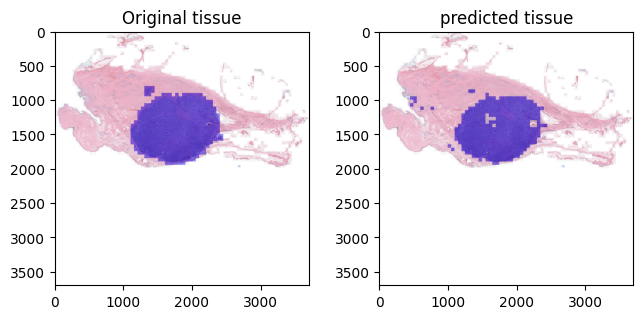

In [15]:
fig, axes = plt.subplots(1, 2)
img1 = original_breast_tissue(13019)
img2 = predicted_breast_tissue(13019)
axes[0].imshow(img1)
axes[1].imshow(img2) 
axes[0].title.set_text('Original tissue')
axes[1].title.set_text('predicted tissue')
#This has more false negatives